# Fine tuning a VLM using the Hugging Face ecosystem (Qwen2-VL-7B)

References:

* https://www.philschmid.de/fine-tune-multimodal-llms-with-trl

* https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/fine-tune-multimodal-llms-with-trl.ipynb


* https://github.com/huggingface/huggingface-llama-recipes/blob/main/fine_tune/sft_vlm.py


* https://github.com/huggingface/huggingface-llama-recipes/blob/main/fine_tune/peft_finetuning.py

* https://huggingface.co/blog/idefics2

* https://github.com/huggingface/huggingface-llama-recipes/tree/main

* https://huggingface.co/blog/vlms

Outline:

* Understand fine-tuning vs. prompting.
* Select a dataset and setup environment
* Check how the base model performs directly
* Fine-tune model using trl
* Test the model
* Test the model using just prompting.

TODO:

* Add validation part to the training.
* Generate an Space with the fine-tuned model.
* Save best model during training
* Add images and explanations


# 1. Install dependencies

In [1]:
!pip install  -U -q git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git datasets bitsandbytes  peft qwen-vl-utils wandb accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 92.6 MB/s eta 0:00:00
   ━━━━

Login to upload fine-tuned model!

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Load dataset

In [23]:
system_message = """You are an expert in analyzing images and answering questions based on the content.
Your answers must always be very short, consisting of either a single word or a single number.
Be concise and precise, providing only the most relevant information in response to the user's question.
"""

In [24]:
# Usage tips! https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct#more-usage-tips
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['query'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["label"][0]
                }
            ],
        },
    ]

In [20]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[:10%]'])

In [21]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [25]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [26]:
print(train_dataset[200])

[{'role': 'system', 'content': [{'type': 'text', 'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369 at 0x7DBE1C327250>}, {'type': 'text', 'text': 'Is the rightmost value of light brown graph 58?'}]}, {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]


# 3. Load model and check how it performs!

In [8]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, BitsAndBytesConfig

model_id = "Qwen/Qwen2-VL-7B-Instruct"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [31]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

In [32]:
train_dataset[0][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

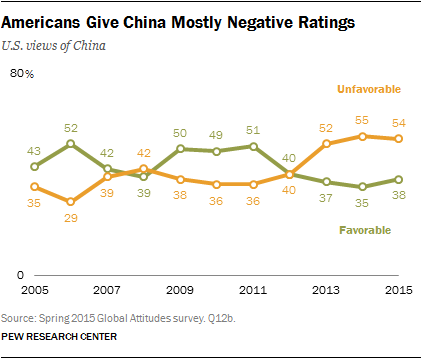

In [33]:
train_dataset[0][1]['content'][0]['image']

In [34]:
from qwen_vl_utils import process_vision_info

text = processor.apply_chat_template(
    train_dataset[0][1:2], tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(output_text[0])

No, the value of Favorable is not 38 in 2015. According to the chart, the value of Favorable in 2015 is 38.


### Remove model and clean GPU

In [35]:
import torch
import gc

del inputs
del model
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()
gc.collect()

0

In [38]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
gc.collect()

0

In [39]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


# 4. Load the quantized model so we can train it

In [26]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = Qwen2VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

# 5. Set up QLoRA and SFTConfig

In [27]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

In [28]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-ChartQA",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=5,
    eval_steps=20,
    evaluation_strategy="steps",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=True,
    report_to="wandb",
    gradient_checkpointing_kwargs = {"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs = {"skip_prepare_dataset": True}
)
training_args.remove_unused_columns=False

In [29]:
import wandb

wandb.init(
    project="qwen2-7b-instruct-ChartQA",  # change this
    name="qwen2-7b-instruct-ChartQA",  # change this
    config=training_args,
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
# https://github.com/huggingface/trl/blob/a67f2143c38d6520be8735463ce715ad5c281db8/examples/scripts/sft_vlm.py#L87
from qwen_vl_utils import process_vision_info

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example)[0] for example in examples]

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):
        image_tokens = [151652,151653,151655]
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100
    batch["labels"] = labels

    return batch

In [31]:
from trl import SFTTrainer

#Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    dataset_text_field="", # needs dummy value
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:310: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:329: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:404: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due 

In [32]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,22.974800
10,18.471300
15,13.234400
20,8.702200
25,6.389000
30,5.565700
35,5.311700
40,4.925000
45,4.582300
50,3.981100


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


KeyboardInterrupt: 

In [33]:
trainer.save_model(training_args.output_dir)

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

# 6. Test the fine-tuned model!

https://github.com/QwenLM/Qwen2-VL?tab=readme-ov-file#quantize-your-own-model-with-autoawq

In [ ]:
import torch
import gc

#del inputs
del model
del trainer
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()
gc.collect()

In [106]:
torch.cuda.empty_cache()
torch.cuda.synchronize()
gc.collect()

76

In [107]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.06 GB


In [40]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
adapter_path = "sergiopaniego/qwen2-7b-instruct-ChartQA"
model.load_adapter(adapter_path)

adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [43]:
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': "You are an expert in analyzing images and answering questions based on the content.\nYour answers must always be very short, consisting of either a single word or a single number.\nBe concise and precise, providing only the most relevant information in response to the user's question.\n"}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

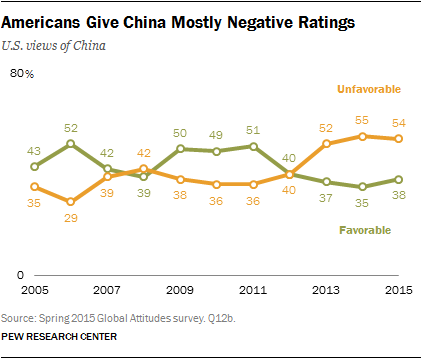

In [44]:
train_dataset[0][1]['content'][0]['image']

In [42]:
from qwen_vl_utils import process_vision_info

text = processor.apply_chat_template(
    train_dataset[0][1:2], tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(output_text[0])

Yes


# 7. Compare fine-tuned model vs. base model + prompting